# COMP767 Assignment 5 : GVFs and SR 



## Common Question 
**Explain how SR can be expressed in the GVF framework (also see corresponding section in S&B if necessary). Explain this connection using the GVF terminology: cumulant (this is not the notion of “moments” of a prob. distribution), termination condition, etc.** 



### Terminalogy explanation

GVF generalizes the reward that we always deal with to arbitrary signals. Rather than predicting the sum of future rewards, other signals like sound or color sensation can also be predicted. These signals that can be added up in a value-function-like prediction are called **cumulant signals**. Similar to the reward signal, there is an equivalent function as value function for cumulant signals that can be learned using usual RL methods and we call these functions **prediction** or **forecast**. These predictions are extra tasks, in-addition-to, the main task of maximizing reward and they are called **auxiliary** tasks. Auxiliary tasks can help on the main task in several ways: by learning the representations that required by the main task as well in a simpler and faster way; by reflexive association to a particular action from the prediction of a particular signal (built-in algorithms without learning), etc. 

### Explain SR in GVF framework 
SR can be explained using GVF framework by showing how SR learns the distribution of future states (successors) starting from each state instead of future rewards. The cumulant signal is the feature vector $\phi_\pi(s)=e_s^T(I-\gamma P_\pi)^{-1}$ and can be predicted using RL methods (e.g. TD(0)). SR is an auxiliary task that learns a representation that is required by the main task (maximizing the future reward) because the value function is associated with $\phi$ in this way: $v_\pi (s)=\phi_\pi(s)^T r_\pi$. So to learn the value function, SR learns the GVF of the feature matrix $\phi$ first. Then the value function can be calculated using GVF. Experiments showed that learning feature matrix $\phi$ is faster than learning the reward function directly. 

* $r_\pi(s) = \sum_{a} \pi(a|s) r(s,a)$  
* $P_\pi(s,s') = \sum_a \pi(a|s)P(s'|s,a)$

## Learning SR 
In a grid world, learn SR using TD(0) update rule. 

In [3]:
# install Pycolab
! pip install git+https://github.com/deepmind/pycolab.git 

  Cloning https://github.com/deepmind/pycolab.git to /tmp/pip-_cZUlJ-build
  Running setup.py install for pycolab ... - done


In [0]:
import numpy as np
import matplotlib.pyplot as plt

from pycolab import ascii_art
from pycolab.prefab_parts import sprites as prefab_sprites

### Environment 
Define grid world environment using Pycolab. 

In [0]:
class PlayerSprite(prefab_sprites.MazeWalker):
    def __init__(self, corner, position, character):
        """Inform superclass that we can go anywhere, but not off the board."""
        super(PlayerSprite, self).__init__(
            corner, position, character, impassable='#', confined_to_board=True)

    def update(self, actions, board, layers, backdrop, things, the_plot):
        del layers, backdrop, things  # Unused.

        # Apply motion commands.
        if actions == 0:  # walk upward?
            self._north(board, the_plot)
        elif actions == 1:  # walk downward?
            self._south(board, the_plot)
        elif actions == 2:  # walk leftward?
            self._west(board, the_plot)
        elif actions == 3:  # walk rightward?
            self._east(board, the_plot)
        else:
            # All other actions are ignored. Although humans using the CursesUi can
            # issue action 4 (no-op), agents should only have access to actions 0-3.
            # Otherwise staying put is going to look like a terrific strategy.
            return

        # See if the game is over.
        if self.position[0] == 0 and self.position[1] == 3:
            the_plot.add_reward(0.0)
            the_plot.terminate_episode()
        else:
            the_plot.add_reward(-1.0)

class MazeEnv:
    def __init__(self, maze_index=0, useRandomMaze=False):
        self.ENV_GAME_ART = [
            ['....',
             '....',
             '....',
             '.P..'],
        ]

        self.maze_index = np.random.randint(len(self.ENV_GAME_ART)) if useRandomMaze else maze_index

        self.game = self.make_game()

        self.observation_space_n = self.game.rows * self.game.cols

        self.actions = [0, 1, 2, 3]
        self.action_space_n = len(self.actions)

        self.episode = 0

    def make_game(self):
        """Builds and returns a cliff-walk game."""
        return ascii_art.ascii_art_to_game(
            self.ENV_GAME_ART[self.maze_index], what_lies_beneath='.',
            sprites={'P': PlayerSprite})

    def get_state(self, obs):
        allstates = np.array(obs.layers['P'], dtype=np.float)
        s = np.argmax(allstates, axis=None)
        return s

    def reset(self):
        self.game = self.make_game()  # blockingMaze.make_game(self.mazeIndex)
        self.episode = 0
        obs, r, gamma = self.game.its_showtime()
        return self.get_state(obs)

    def step(self, action):
        self.episode += 1
        obs, reward, gamma = self.game.play(action)
        next_state = self.get_state(obs)
        return next_state, reward, self.game.game_over

In [78]:
# define env
env = MazeEnv()
state = env.reset()
print(state)
next_state, R, done = env.step(0) 
print(next_state, R, done)

13
(9, -1.0, False)


### Ground truth
Calculate ground truth of $\phi(s)$. Plot. 

In [0]:
def find_ground_truth(dimension, terminal):
    dimension = dimension
    states = list(range(dimension**2))
    terminal = terminal
    # create distribution and rewards
    p = []
    r = []
    for s in states:
        # find its neighbours: [left, right, up, down]
        nb = [s - 1, s + 1, s - 4, s + 4]
        nb = [x if (x in states) else s for x in nb]
        if s % 4 == 0:
            nb[0] = s
        elif s % 4 == 3:
            nb[1] = s
        p_s2_s_a = []
        for next_state in states:
            if (next_state in nb) and (s not in terminal):
                p_s2_s_a.append([0.25 if x == next_state else 0 for x in nb])
            else:
                p_s2_s_a.append([0, 0, 0, 0])
        p.append(p_s2_s_a)
        r.append([0 if x in terminal else -0.25 for x in nb])
    
    p = [[sum(action) for action in row] for row in p]
    p = np.array(p, np.float)
    r = np.array(r, np.float)
    r_s = np.array([sum(x) for x in r])
    
    gamma = 0.95
    I = np.diag(np.diag(np.ones([16, 16])))
    features = np.linalg.inv(I - gamma * p)
    phi = []
    for state in states:
        e = np.zeros(16)
        e[state] = 1
        phi.append(np.dot(e.T, features))
    
    phi = np.array(phi)
    # print('phi = ', np.round(phi, 2))
    
    v = np.dot(phi, r_s.T)
    
    print('value = ', np.round(v, 2))
    
    return r_s, phi ,v 
    

('value = ', array([-14.82, -13.19,  -9.01,  -0.5 , -15.36, -14.3 , -12.07,  -9.01,
       -15.99, -15.39, -14.3 , -13.19, -16.37, -15.99, -15.36, -14.82]))


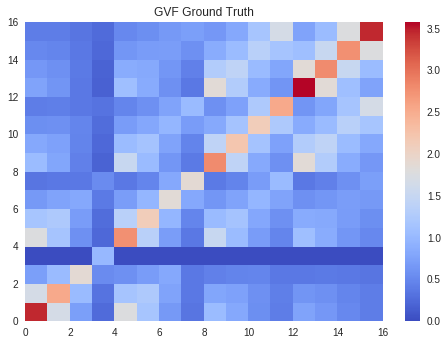

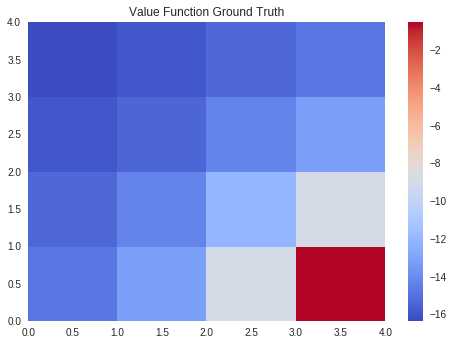

In [72]:
r_s, phi_ground_truth, v_ground_truth = find_ground_truth(dimension=4, terminal=[3])

plt.pcolormesh(phi_ground_truth, cmap='coolwarm')
plt.colorbar()
plt.title('GVF Ground Truth')
plt.show()

v_ground_truth = np.reshape(v_ground_truth, (-1,4))
plt.pcolormesh(v_ground_truth, cmap='coolwarm')
plt.colorbar()
plt.title('Value Function Ground Truth')
plt.show()

### Algorithm Implementation 
Implement TD(0) and SR_TD(0). 

In [0]:
class TD0:
    def __init__(self, env, states, actions, pi, epsilon=0.1, alpha=0.3, gamma=0.95, episode=100):
        self.env = env
        self.states = states
        self.actions = actions
        self.pi = pi
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.episode = episode

        self.v = np.zeros(len(self.states))

    def learn(self):
        for i in range(self.episode):
            if i%100 ==0: print('Episode ', i)
            s = self.env.reset()
            done = False
            while not done:
                action = np.random.choice(self.actions, size=1, p=self.pi[s])[0]
                next_s, r, done = self.env.step(action)
                self.v[s] += self.alpha * (r + self.gamma * self.v[next_s] - self.v[s])
                s = next_s


In [0]:
class SR_TD0(TD0):
    def __init__(self, env, states, actions, pi, epsilon=0.1, alpha=0.5, gamma=0.95, episode=100):
        TD0.__init__(self, env, states, actions, pi, epsilon=epsilon, alpha=alpha, gamma=gamma, episode=episode)
        self.phi = np.zeros((16,16))

    def learn(self):
        for i in range(self.episode):
            if i % 100 == 0: print('Episode ', i)
            s = self.env.reset()
            done = False
            while not done:
                action = np.random.choice(self.actions, size=1, p=self.pi[s])[0]
                next_s, r, done = self.env.step(action)
                for j in self.states:
                    indicator = 1 if j==s else 0
                    self.phi[s][j] += self.alpha * (indicator + self.gamma * self.phi[next_s][j] - self.phi[s][j])
                s = next_s

### Learn SR 

In [73]:
# run SR
env = MazeEnv()
dimension = 4
states = list(range(dimension**2))
pi = 0.25*np.ones((16,4))
sr = SR_TD0(env=env, states=states, actions=env.actions, pi=pi, alpha=0.1, episode=2000)
sr.learn()

('Episode ', 0)
('Episode ', 100)
('Episode ', 200)
('Episode ', 300)
('Episode ', 400)
('Episode ', 500)
('Episode ', 600)
('Episode ', 700)
('Episode ', 800)
('Episode ', 900)
('Episode ', 1000)
('Episode ', 1100)
('Episode ', 1200)
('Episode ', 1300)
('Episode ', 1400)
('Episode ', 1500)
('Episode ', 1600)
('Episode ', 1700)
('Episode ', 1800)
('Episode ', 1900)


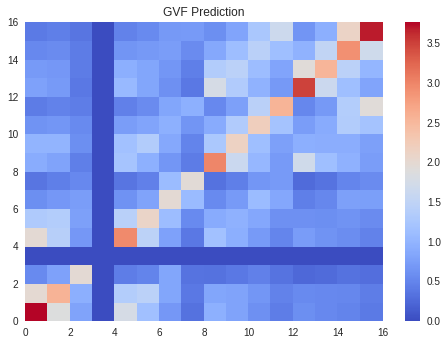

In [74]:
# print(np.round(sr.phi,2))
plt.pcolormesh(sr.phi, cmap='coolwarm')
plt.colorbar()
plt.title('GVF Prediction')
plt.show()

### Difference between SR and ground truth

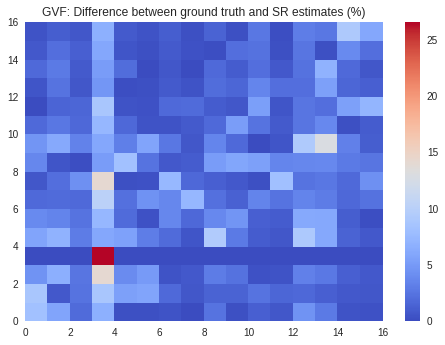

In [75]:
# difference map
diff = np.abs(ground_truth_phi - sr.phi) / max(np.abs(ground_truth_phi).max(), np.abs(sr.phi).max()) * 100

plt.pcolormesh(diff, cmap='coolwarm')
plt.colorbar()
plt.title("GVF: Difference between ground truth and SR estimates (%)")
plt.show()

## Value Prediction with SR
Using the SR learned in part 1, predict the value function for “pi” given a reward function of your choice. Compare the predicted values with the ground truth (exact solution, or with TD(0)). 

### Predicted value function 
Using $\phi(s)$ predicted from SR above ($sr.phi$), calculate value function by $v_\pi (s)=\phi_\pi(s)^T r_\pi$. 

In [90]:
v_sr = np.dot(sr.phi, r_s.T)

v_sr = np.reshape(v_sr, (-1, 4))
print('value = ', np.round(v_sr, 2))

('value = ', array([[-14.14, -12.24,  -7.74,   0.  ],
       [-15.13, -14.36, -11.57, -11.09],
       [-15.98, -15.41, -14.96, -14.75],
       [-16.26, -15.96, -15.57, -15.31]]))


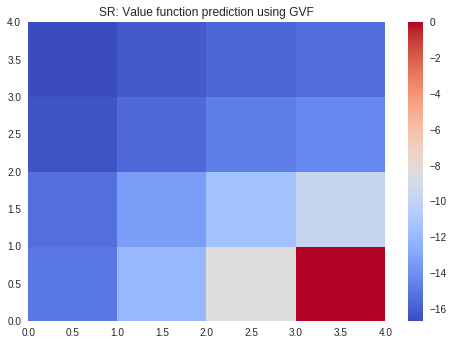

In [76]:
plt.pcolormesh(v_sr, cmap='coolwarm')
plt.colorbar()
plt.title("SR: Value function prediction using GVF")
plt.show()

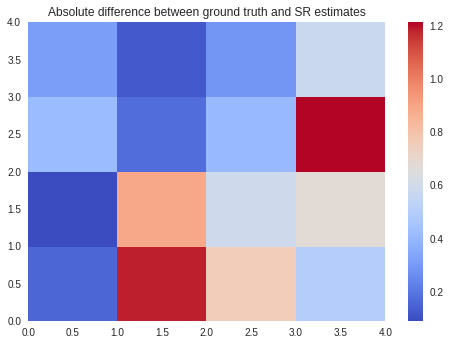

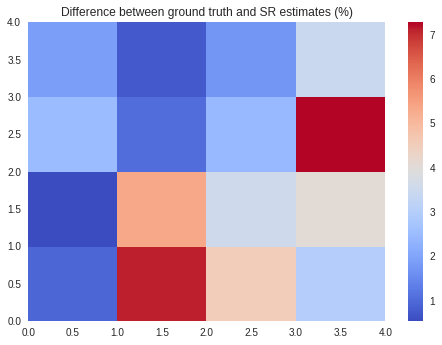

In [78]:
# difference map between SR and ground truth
diff = np.abs(v_sr - v_ground_truth) 
percent_diff = diff / max(np.abs(v_sr).max(), np.abs(v_ground_truth).max()) * 100

plt.pcolormesh(diff, cmap='coolwarm')
plt.colorbar()
plt.title("Absolute difference between ground truth and SR estimates")
plt.show()

plt.pcolormesh(percent_diff, cmap='coolwarm')
plt.colorbar()
plt.title("Difference between ground truth and SR estimates (%)")
plt.show()


### TD(0) ground truth 
Find value function using TD(0). 

In [92]:
# run td0
env = MazeEnv()
dimension = 4
states = list(range(dimension**2))
pi = 0.25*np.ones((16,4))
td0 = TD0(env=env, states=states, actions=env.actions, pi=pi, alpha=0.1, episode=2000)
td0.learn()

v_td = np.reshape(td0.v, (-1, 4))
print(np.round(v_td, 2))


('Episode ', 0)
('Episode ', 100)
('Episode ', 200)
('Episode ', 300)
('Episode ', 400)
('Episode ', 500)
('Episode ', 600)
('Episode ', 700)
('Episode ', 800)
('Episode ', 900)
('Episode ', 1000)
('Episode ', 1100)
('Episode ', 1200)
('Episode ', 1300)
('Episode ', 1400)
('Episode ', 1500)
('Episode ', 1600)
('Episode ', 1700)
('Episode ', 1800)
('Episode ', 1900)
[[-13.51 -11.66  -8.18   0.  ]
 [-14.64 -13.71 -11.76  -7.56]
 [-15.59 -14.97 -14.69 -12.37]
 [-16.13 -15.83 -15.23 -14.18]]


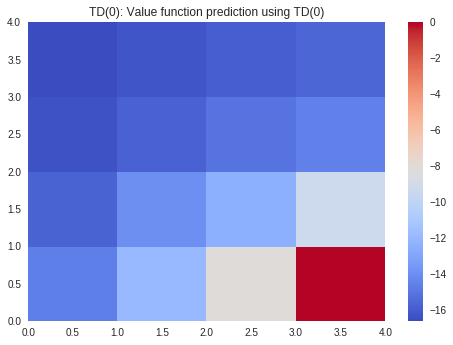

In [77]:
plt.pcolormesh(v_td, cmap='coolwarm')
plt.title("TD(0): Value function prediction using TD(0)")
plt.colorbar()
plt.show()

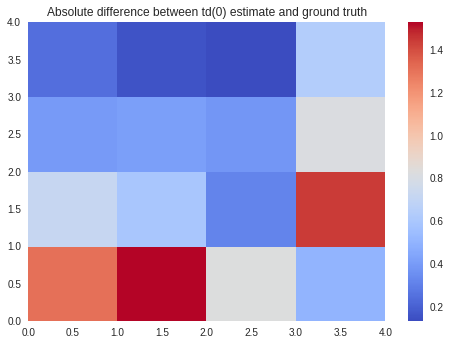

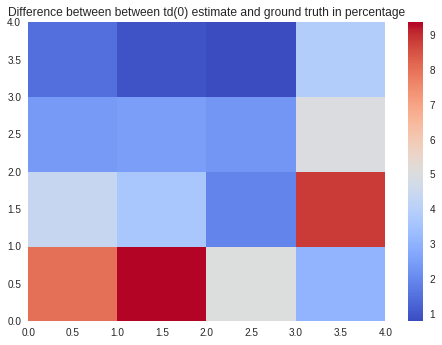

In [99]:
# difference map between ground truth and td(0)
diff = np.abs(v_td - v_ground_truth) 
percent_diff = diff / max(np.abs(v_td).max(), np.abs(v_ground_truth).max()) * 100

plt.pcolormesh(diff, cmap='coolwarm')
plt.colorbar()
plt.title("Absolute difference between td(0) estimate and ground truth")
plt.show()

plt.pcolormesh(percent_diff, cmap='coolwarm')
plt.colorbar()
plt.title("Difference between between td(0) estimate and ground truth in percentage")
plt.show()

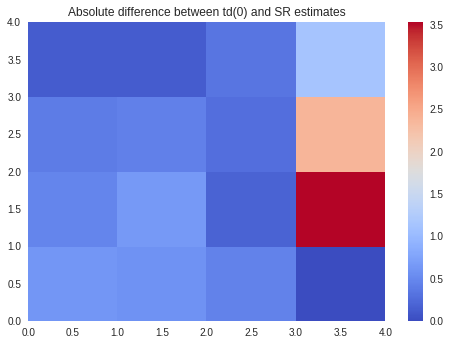

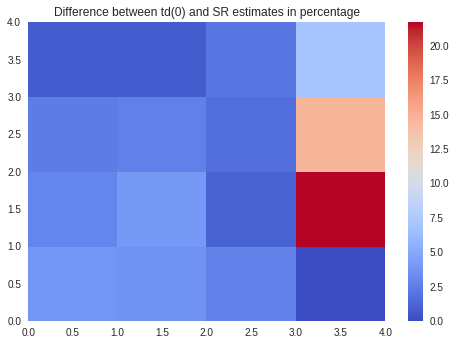

In [97]:
# difference map between SR and td(0)
diff = np.abs(v_sr - v_td) 
percent_diff = diff / max(np.abs(v_sr).max(), np.abs(v_td).max()) * 100

plt.pcolormesh(diff, cmap='coolwarm')
plt.colorbar()
plt.title("Absolute difference between td(0) and SR estimates")
plt.show()

plt.pcolormesh(percent_diff, cmap='coolwarm')
plt.colorbar()
plt.title("Difference between td(0) and SR estimates in percentage")
plt.show()

According to our results, lowering the learning rates of the algorithms made the difference decrease, thus we can deduce that lower learning rates improve the accuracy of SR. Since we implemented td(0) and ground truth value map computation, we compared the results of SR to both of these. The heat maps shown above depict the differences between the estimates of SR and ground truth, td(0) and ground truth, as well as between SR and td(0). Our result show that the estimates given by td(0) differ from ground truth by up to 9% while estimates given by SR differ by up to 7%. This suggests that the results given by SR are slightly more accurate than those given by td(0). Note that the estimates given by td(0) and SR differ by up to 20%. 